# Week2授業課題2

In [2]:
import numpy as np
csv_path = "/Users/tamiyagt/Documents/Machine Learning/99_Resources/mtfuji_data.csv" # ファイル名（パス）を指定する
np.set_printoptions(suppress=True) # 指数表示の禁止を設定する
fuji = np.loadtxt(csv_path, delimiter=",", skiprows=1)

print((fuji))

[[    0.          35.134141   139.132082     0.           0.      ]
 [    1.          35.135826   139.129202     0.         322.      ]
 [    2.          35.13751    139.126322     0.         644.      ]
 ...
 [  297.          35.631284   138.271368  1973.99     95698.      ]
 [  298.          35.632947   138.268452  1841.36     96020.      ]
 [  299.          35.63461    138.265536  1725.8      96343.      ]]


## 【問題1】データの可視化
Matplotlibを使い標高データを可視化してください。横軸に「その地点の番号」、縦軸に「標高」を設定すれば、富士山の断面図が描けます。

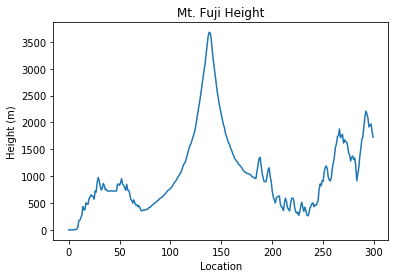

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(fuji[:, 0], fuji[:, 3])
ax.set_title('Mt. Fuji Height')
ax.set_xlabel('Location')
ax.set_ylabel('Height (m)')
plt.show()

## 【問題2】ある地点の勾配を計算する関数を作成
「二次元配列と勾配問題」では各地点での勾配を最初に求めました。しかし、暗闇の富士山を想像すると、知ることができるのは今いる地点の勾配だけです。

「今いる地点の番号」と「今いる隣の地点の番号（今いる地点の番号-1）」の関係による勾配を求める関数を作成してください。

勾配は以下の式で求まりましたが、このデータでは「標高」がy、「その地点の番号」がxに相当します。

In [4]:
#方法1 勾配を求める関数を作成
def grad_fuji(x):
    
    #gradの要素数は地点番号より-1のため、x地点の返り値はgradのインデックス[x-1]と設定
    #また、負数のインデックスが抽出されないよう、下記if文を設定
    if x <= 0:
        x = 0
    else:
        x -= 1
    
    dx = fuji[1:, 0] - fuji[:-1, 0]
    dy = fuji[1:, 3] - fuji[:-1, 3]
    
    grad = dy/dx
    
    return grad[x]  
    
    
#方法2　勾配リストを元データに結合し、各地点の勾配をインデックスより求める
dx = fuji[1:, 0] - fuji[:-1, 0]
dy = fuji[1:, 3] - fuji[:-1, 3]

grad = np.array(0)
grad = np.append(grad, dy/dx)

fuji_plus_grad = np.concatenate((fuji, grad.reshape(-1, 1)), axis=1)

>**メモ**<br>
>方法１のコメントにも記載した通り、勾配の要素数は地点数（元データ）より一つ少ない。そのため、上記関数を使用して地点xの勾配を求める場合は、引数に地点x-1を与える必要がある。これをif文を用いて実装。
>負数によるエラーやコードの見やすさのため、残りの問題では方法２で作成した、勾配データを追加したndarrayを使用する。

## 【問題3】移動先の地点を計算する関数を作成
今いる地点の勾配の情報を元に、次に移動先の地点を計算する関数を作成してください。

数式で表すと 「移動先の地点 = 今いる地点 - $α$ ×今いる地点の勾配」 となります。

「今いる地点の勾配」は問題2で作成した関数の返り値を使用してください。$α$は0より大きい任意の値をとるハイパーパラメータです。機械学習の分野では学習率という名前で呼ばれます。この値によって下り方が変わります。ここでは例えば0.2に設定してください。

《実装上の注意》

上記式を計算すると移動先の地点には浮動小数点数が現れますが、今回勾配の情報を得るためには地点は整数で表す必要があります。そのため、四捨五入による変換を行ってください。また、取り得ない値となった場合の処理が必要です。例えば移動先の地点が負になると、そのようなデータが存在しないため、次に勾配が得られなくなります。

《ハイパーパラメータとは》

機械学習手法において、その手法自身では最適化が行えない値のことです。値によって手法の挙動は変化し、学習がうまくいくかどうかに影響を与えるため、設定は慎重に行う必要があります。最も単純には人間が考えて設定することになりますが、ハイパーパラメータを機械的に決めるための手法も存在します。

In [5]:
print(type(fuji_plus_grad[100,5]))

<class 'numpy.float64'>


In [26]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

def new_loc(x, a=0.2):

    x_new = x - a*fuji_plus_grad[x,5]

    # 新しい地点が範囲外の場合は0または299に設定
    if x_new < 0:
        x_new = 0
    if x_new > 299:
        x_new = 299
    
    x_new_round = Decimal(x_new).quantize(Decimal('0'), rounding=ROUND_HALF_UP)

    return x_new_round

print(new_loc(136))

102


## 【問題4】山を下る関数を作成
山を下る関数を作成してください。最初の地点を受け取り、問題3の関数によって地点を更新していきます。移動毎の地点はリストなどに記録して、これを関数の返り値としてください。

最初の「今いる地点」は富士山の頂上付近、136番の地点（標高3434.59[m]）とします。ここから山を下っていきましょう。

《実装上の注意》

問題3で四捨五入を行っているため、移動先の地点が今いる地点と同じ場合になることがあります。移動量が減ってきたということなので、その時点で山を下りきったと判断してください。実際の勾配降下法ではこのようなことは起きません。

In [14]:
def descend_fuji(x=136, a=0.2):
    
    path_list = np.array(x)
    
    while True:

        x_new = int(new_loc(x, a))
        path_list = np.append(path_list, x_new)
        
        if len(path_list) != len(set(path_list)):
            break
        elif x_new < 0:
            break
            
        x = x_new
        
    return path_list

print(descend_fuji(136))


[136 102  98  95  93  89  85  82  79  73  70  78  77  75  75]


## 【問題5】下山過程の可視化
問題4における下山過程をMatplotlibを使いグラフで可視化してください。

《可視化例》

- 断面図の中に移動した地点を点で表示する
- 繰り返し毎の標高や勾配を折れ線グラフにする

In [137]:
# 下山工程の関数作成

def plot_descent(x, a=0.2):

    fuji_journey = descend_fuji(x)

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    ax2 = ax1.twinx()
    
    c = np.arange(len(fuji_journey))

    # 下山行程の各地点を可視化
    ax.plot(fuji[:, 0], fuji[:, 3])
    ax.scatter(fuji_journey, fuji_plus_grad[fuji_journey, 3], color='orange', alpha='1', label='Path')
    ax.set_title('Path of Fuji Descent (x = {}, $\\alpha$ = {})'.format(x, a))
    ax.set_xlabel('Location')
    ax.set_ylabel('Height (m)')
    ax.legend(loc='upper left')

    # 下山工程の標高と勾配を可視化
    ax1.plot(fuji_journey, fuji_plus_grad[fuji_journey, 3], label='Height')
    ax1.scatter(fuji_journey, fuji_plus_grad[fuji_journey, 3],
                c=c, cmap='Blues', marker='v', s=100)
    ax2.plot(fuji_journey, fuji_plus_grad[fuji_journey, 5], label='Gradient', c='orange')
    ax2.scatter(fuji_journey, fuji_plus_grad[fuji_journey, 5],
                c=c, cmap='Oranges', marker='v', s=100)
    ax1.set_title('Height and Gradient of Fuji Descent (x = {}, $\\alpha$ = {})'.format(x, a))
    ax1.set_xlabel('Location')
    ax1.set_ylabel('Height (m)')
    ax2.set_ylabel('Gradient (m)')

    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(handler1+handler2, label1+label2, loc='best')

    plt.show()

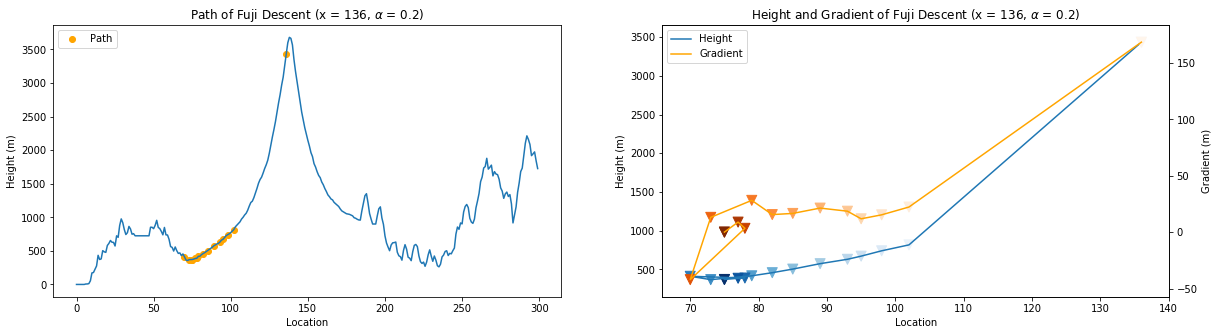

In [138]:
# 地点136番からの下山工程を可視化
plot_descent(136)

>標高および勾配のグラフでは終着点に近づくにつれてマーカーが段々と濃くなるように描画した。

## 【問題6】初期値の変更
問題4では最初の「今いる地点」を136としましたが、これを他の全ての点で計算してください。そして、いくつかの初期値に対してどのような下山過程となるか、問題5のように可視化してください。機械学習においては 初期値 をどう設定するかが結果に影響を与えることが確認できます。

《初期値とは》

今回の例での最初の地点のような値を初期値と呼びます。これを変更すると結果が変化します。例えば136と142では富士山の異なるの斜面を下ることになります。

In [142]:
# 全ての地点を初期値とした下山過程

endpoints = []

for i in range(1, 300):
    
    descent = descend_fuji(i)
    
    # 終着点をリスト化
    endpoints.append(descent[-1])
    
    print(descent)

[1 1]
[2 2]
[3 3]
[4 4]
[5 5]
[6 5 5]
[7 7]
[8 7 7]
[9 1 1]
[10  0  0]
[11 10  0  0]
[12  2  2]
[13  4  4]
[14  0  0]
[15 27 31 51 41 41]
[16 14  0  0]
[17  0  0]
[18 22 13  4  4]
[19 21 15 27 31 51 41 41]
[20  0  0]
[21 15 27 31 51 41 41]
[22 13  4  4]
[23 28  0  0]
[24 24]
[25 36 52 37 35 43 43]
[26  0  0]
[27 31 51 41 41]
[28  0  0]
[29 10  0  0]
[30 41 41]
[31 51 41 41]
[32 47 47]
[33 27 31 51 41 41]
[34 15 27 31 51 41 41]
[35 43 43]
[36 52 37 35 43 43]
[37 35 43 43]
[38 44 44]
[39 39]
[40 40]
[41 41]
[42 42]
[43 43]
[44 44]
[45 45]
[46 46]
[47 47]
[48 22 13  4  4]
[49 49]
[50 54 58 80 80]
[51 41 41]
[52 37 35 43 43]
[53 74 74]
[54 58 80 80]
[55 63 74 74]
[56 66 74 74]
[57 35 43 43]
[58 80 80]
[59 59]
[60 73 70 78 77 75 75]
[61 83 80 80]
[62 64 52 37 35 43 43]
[63 74 74]
[64 52 37 35 43 43]
[65 76 75 75]
[66 74 74]
[67 66 74 74]
[68 76 75 75]
[69 64 52 37 35 43 43]
[70 78 77 75 75]
[71 81 77 75 75]
[72 73 70 78 77 75 75]
[73 70 78 77 75 75]
[74 74]
[75 75]
[76 75 75]
[77 75 75]
[78

In [143]:
# 終着点の頻度をDataFrameに格納

import pandas as pd

endpoint, frequency = np.unique(endpoints, return_counts=True)

end_freq = pd.DataFrame({'Endpoint': endpoint,
                         'Frequency': frequency
                        }).sort_values('Frequency', ascending=False)

# 表を出力
end_freq

,Endpoint,Frequency
20,75,68
40,239,53
27,178,35
43,299,16
42,249,13
10,41,10
12,43,10
0,0,10
26,177,8
19,74,7


>全ての地点から下山した場合の終着点をまとめ、頻度をヒストグラムとして確認する。この場合の$\alpha$は0.2とした。結果として、75番、239番、178番地点に終着する頻度が高いことがわかる。これらの地点は富士山の低地だと確認できるため、下山関数はうまく機能したと思われる。

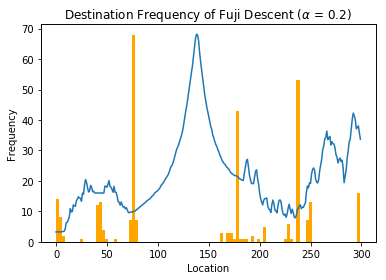

In [145]:
# 終着点の頻度を可視化
%matplotlib inline

plt.hist(endpoints, bins=100, color='orange')
plt.title('Destination Frequency of Fuji Descent ($\\alpha$ = 0.2)')
plt.xlabel('Location')
plt.ylabel('Frequency')

plt.twinx()
plt.plot(fuji[:, 0], fuji[:, 3])
plt.yticks(ticks=[])

plt.show()

>最後に、いくつかの地点からの下山工程を確認する（$\alpha$ = 0.2）。<br>
>①頂点からの下山、②右斜面を降る工程、③および260と290番付近のピークからの下山工程を調査する。

In [96]:
# 各地点を確認

print("頂上の地点：{}".format(fuji[:,3].argmax()))
print("頂上から右斜面を降る初期地点：{}".format(fuji[:,3].argmax() + 1))
print("260付近のピーク地点：{}".format(fuji[250:276,3].argmax() + 250))
print("290付近のピーク地点：{}".format(fuji[276:299,3].argmax() + 276))

頂上の地点：138
頂上から右斜面を降る初期地点：139
260付近のピーク地点：266
290付近のピーク地点：292


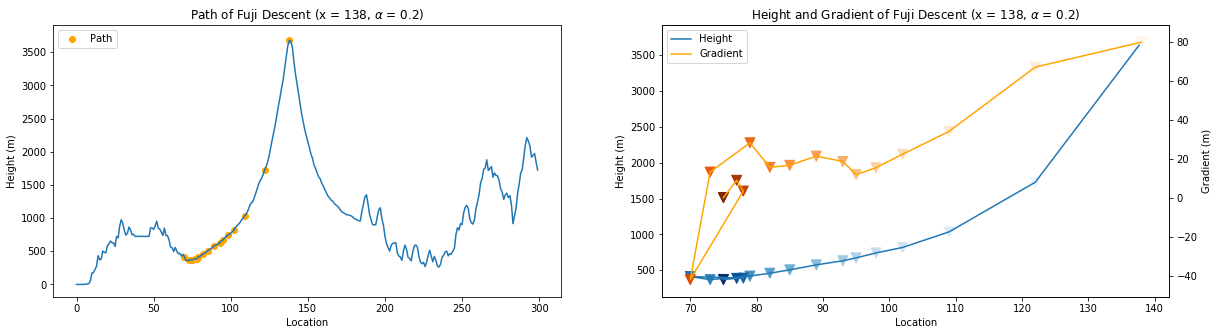

終着点：75


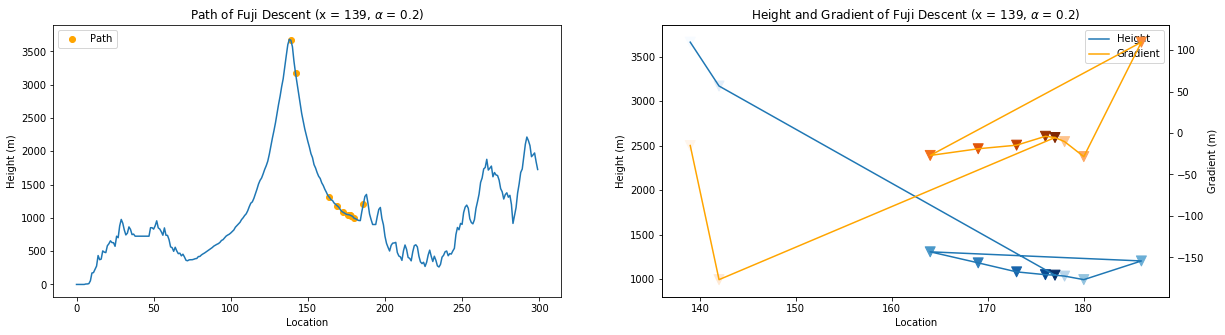

終着点：177


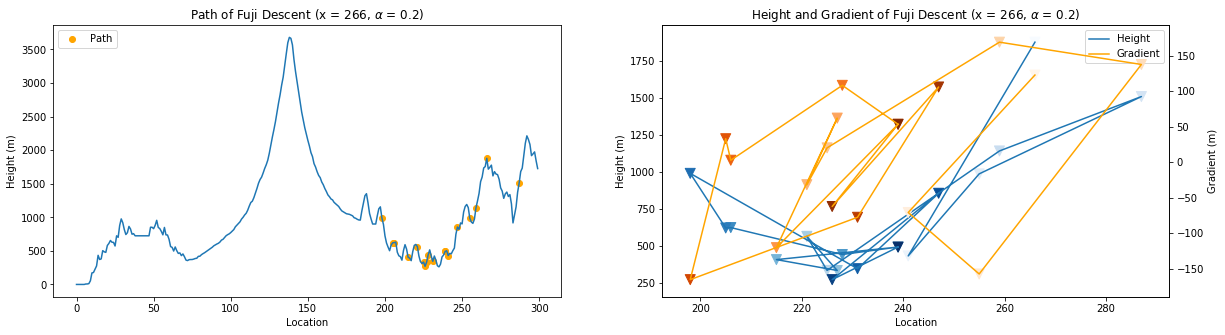

終着点：239


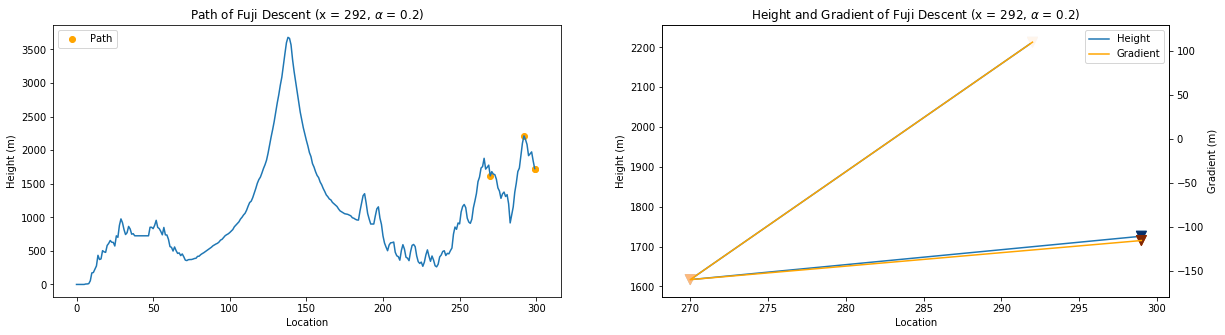

終着点：299


In [139]:
# 各地点の下山工程を可視化

%matplotlib inline

for i in [138, 139, 266, 292]:
    
    plot_descent(i)
    print("終着点：{}".format(descend_fuji(i)[-1]))

## 【問題7】（アドバンス問題）ハイパーパラメータの変更
ハイパーパラメータ$α$を変化させるとどのような下山過程となるか、問題5のように可視化してください。そして、ハイパーパラメータにより結果が大きく異なることを確認してください。

In [160]:
# 終着点の算出および描画を関数化

def gather_endpoints(a=0.2, plot=False):

    endpoints = [descend_fuji(i, a)[-1] for i in range(1,300)]

    endpoint, frequency = np.unique(endpoints, return_counts=True)

    end_freq = pd.DataFrame({'Endpoint': endpoint,
                             'Frequency': frequency
                            }).sort_values('Frequency', ascending=False)
    
    if plot:
        plt.hist(endpoints, bins=100, color='orange')
        plt.title('Destination Frequency of Fuji Descent ($\\alpha$ = {})'.format(a))
        plt.xlabel('Location')
        plt.ylabel('Frequency')

        plt.twinx()
        plt.plot(fuji[:, 0], fuji[:, 3])
        plt.yticks(ticks=[])

        plt.show()
    
    
    return endpoints, end_freq    

>以下のハイパーパラメータによる下山過程を調査する。<br>
$$
\alpha=0.01, 0.1, 0.5, 1, 5, 10
$$

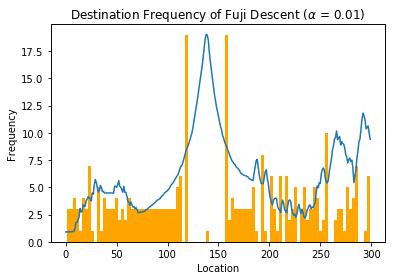

a = 0.01の終着点
     Endpoint  Frequency
90        120         19
92        158         19
150       257         10
163       286          7
120       203          6


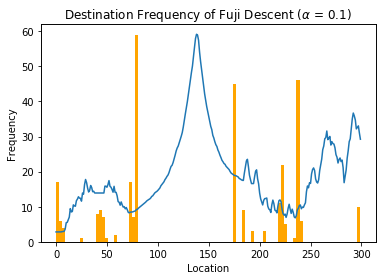

a = 0.1の終着点
    Endpoint  Frequency
25        80         58
35       239         46
26       176         45
32       224         22
0          0         15


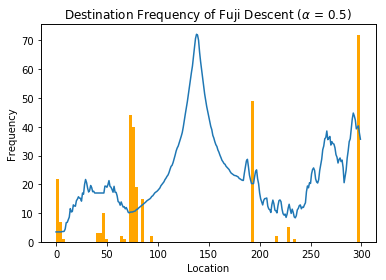

a = 0.5の終着点
    Endpoint  Frequency
32       299         72
19        73         44
28       194         40
21        76         31
22        79         19


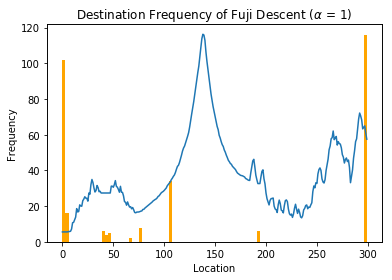

a = 1の終着点
    Endpoint  Frequency
20       299        116
2          2         53
0          0         48
17       107         34
3          3         12


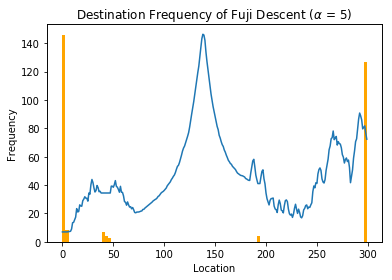

a = 5の終着点
    Endpoint  Frequency
0          0        140
17       299        127
4          4          5
2          2          3
8         41          3


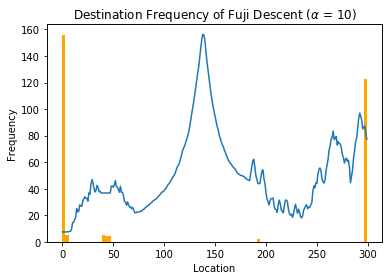

a = 10の終着点
    Endpoint  Frequency
0          0        152
17       299        123
7         40          3
1          1          3
3          3          2


In [182]:
# ハイパーパラメータのリスト作成
alpha = [0.01, 0.1, 0.5, 1, 5, 10]

# 各ハイパーパラメータの終着点の傾向を算出・描画
for a in alpha:
    endpoints, end_freq = gather_endpoints(a, plot=True)
    print("a = {}の終着点".format(a))
    print(end_freq.head())

>$\alpha$のが小さいほど、下山終着点は収束しない傾向にあり、$\alpha$が0.1で終着点が低地に収束し出す。そして、値が大きくなるにつれ、終着点は0または299に収束する。これは下山行程を算出する関数で地点の範囲を0~299と定めたことに起因する。